# Model Explainability (Grad-CAM) - DaViT Baseline

This notebook loads the pre-trained **DaViT (Dual Attention Vision Transformer)** baseline model and uses **Grad-CAM** (Gradient-weighted Class Activation Mapping) to visualize the regions of an image that influenced the model's prediction (AI-generated vs. Human).

**Prerequisites:**
- A trained model file (e.g., `best_model_davit_v1.pth`) must exist.
- The `pytorch-grad-cam` library must be installed.

In [19]:
import os
import torch
import torch.nn as nn
import timm
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from pathlib import Path
import random

# Explainability libraries
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


In [20]:
# --- Configuration ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
IMG_SIZE = 256

MODEL_NAME = 'convnext_base.clip_laion2b_augreg_ft_in1k' 
# MODEL_NAME = 'vit_small_patch14_dinov2.lvd142m' # Example if you used this one

MODEL_PATH = 'best_model.pth' 

IMAGES_DIR = "train" 
GT_FILE = "train.csv"

SAVE_DIR = "results/v1"
os.makedirs(SAVE_DIR, exist_ok=True)

print(f"Device: {DEVICE}")

Device: cuda


In [21]:
# --- Transforms ---
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [22]:
# --- Load Model ---
def load_trained_model(model_name, model_path, device):
    print(f"Creating model: {model_name}")
    model = timm.create_model(model_name, pretrained=False, num_classes=2)
    
    print(f"Loading weights from {model_path}...")
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    print("Weights loaded successfully.")
    
    model.to(device)
    model.eval()
    return model

model = load_trained_model(MODEL_NAME, MODEL_PATH, DEVICE)

Creating model: convnext_base.clip_laion2b_augreg_ft_in1k
Loading weights from best_model.pth...
Loading weights from best_model.pth...
Weights loaded successfully.
Weights loaded successfully.


In [23]:
# --- Explainability Helpers ---
def get_target_layer(model, model_name):
    """
    Identifies the target layer for Grad-CAM based on model architecture.
    """
    target_layer = None
    
    # ConvNeXt specific
    if 'convnext' in model_name:
        # usually the last block of the last stage
        if hasattr(model, 'stages'):
            target_layer = model.stages[-1].blocks[-1]
            
    # EfficientNet specific
    elif 'efficientnet' in model_name:
        if hasattr(model, 'conv_head'):
            target_layer = model.conv_head
            
    # ResNet / General fallback
    if target_layer is None:
        # Try to find the last Conv2d layer
        layers = [module for module in model.modules() if isinstance(module, nn.Conv2d)]
        if layers:
            target_layer = layers[-1]
            
    # If still None (e.g. ViT), GradCAM might need specific handling for Transformers (reshape_transform)
    # For this snippet, we assume CNN-like or hybrid architectures supported by default
    
    # print(f"Target Layer for Grad-CAM: {target_layer}")
    return target_layer

def run_grad_cam(model, img_tensor, target_layer):
    """
    Generates Grad-CAM heatmap.
    """
    # Initialize GradCAM
    cam = GradCAM(model=model, target_layers=[target_layer])
    
    # Add batch dimension
    input_tensor = img_tensor.unsqueeze(0).to(DEVICE)
    
    # We can target a specific class, or None for the highest predicted class
    targets = None 
    
    # Generate CAM
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    
    # Take the first image in the batch
    grayscale_cam = grayscale_cam[0, :]
    
    return grayscale_cam

def visualize_cam(img_tensor, heatmap, title="Grad-CAM", save_path=None):
    """
    Plots the original image and the heatmap overlay.
    """
    # Denormalize image for visualization
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0, 1)
    
    # Create overlay
    visualization = show_cam_on_image(img_np, heatmap, use_rgb=True)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(visualization)
    plt.title(title)
    plt.axis('off')
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

In [24]:
# --- Run Inference & Explanation on Samples from Folder ---

# 1. Get list of images from the folder
supported_exts = ['*.jpg', '*.jpeg', '*.png', '*.webp', '*.bmp']

image_paths = [os.path.join(IMAGES_DIR, f) for f in os.listdir(IMAGES_DIR) if any(f.lower().endswith(ext[1:]) for ext in supported_exts)]
image_paths

['train\\0008b723838e4238ba471243e082e09e.jpg',
 'train\\000ff55056384d61972bda1b6bd80701.jpg',
 'train\\0014d21f66fc4946a2d0258182cd7e42.jpg',
 'train\\00184133eb7b4f058c974af14f7d1804.jpg',
 'train\\001bb73123984d97aef8a998f004caf4.jpg',
 'train\\00293c1ed9864f10b6f52aad8aa81175.jpg',
 'train\\0140678dc21c407e957da5f8b5f5a79d.jpg',
 'train\\01a187371bd4434f93c7c69511d5056a.jpg',
 'train\\054129afc61747acbbb15d7bba6fc2a1.jpg',
 'train\\1e99d5591c554a16a5ba7a359ff49964.jpg',
 'train\\1fc108d6647f479e89568f9318e965cb.jpg',
 'train\\24c0fba469774271b0e10b77f805e710.jpg',
 'train\\2870b17d857c49c580453f65778634f0.jpg',
 'train\\2ca5c96019ca40b3821a8fa1f0e890a6.jpg',
 'train\\2da5fd24d916403bbde06f8a7cb406c1.jpg',
 'train\\302326472e024993a91e8545a379991f.jpg',
 'train\\3116288cbcc4430faa60ee82ab27e324.jpg',
 'train\\33cea5c78c8a4cd5a48095070ae8fd42.jpg',
 'train\\340d95fa883240488cbccc9a4e727903.jpg',
 'train\\3475a5e15eac4db19f02aaa4ecf4c656.jpg',
 'train\\3a3819732d22486fb6495cf3ea2b79b

In [25]:
df_labels = pd.read_csv(GT_FILE)
df_labels['file_name'] = df_labels['file_name'].str.replace('train_data/', '', regex=False)
label_lookup = dict(zip(df_labels['file_name'], df_labels['label']))
label_lookup

{'a6dcb93f596a43249135678dfcfc17ea.jpg': 1,
 '041be3153810433ab146bc97d5af505c.jpg': 0,
 '615df26ce9494e5db2f70e57ce7a3a4f.jpg': 1,
 '8542fe161d9147be8e835e50c0de39cd.jpg': 0,
 '5d81fa12bc3b4cea8c94a6700a477cf2.jpg': 1,
 '25ea852f30594bc5915eb929682af429.jpg': 0,
 'e67085fb6d814cbabe08f978c738f3f7.jpg': 1,
 '041c36d9269146cdb88e7526e3b91651.jpg': 0,
 '4aea3b876247467c8d3713d4920148ab.jpg': 1,
 '09708379751e44d0bc908d8652d0db3e.jpg': 0,
 '774aeb00dbf44520bf3be78bb600bda9.jpg': 1,
 '2275dc00b50f4183812b5c3930365598.jpg': 0,
 'dea116642f354126b79d048de24010e3.jpg': 1,
 '33a6a93ef8074ef684291557a00a408b.jpg': 0,
 '340014208f2e46afb5fb1b0837bf52cf.jpg': 1,
 'c098c9452c6748ca8d94134d898da05a.jpg': 0,
 'fc9dbe25e2d54014a7fafd53198632f5.jpg': 1,
 '91f5e18cdfde4d6b929561f4ec150bbf.jpg': 0,
 'a02c596a83164f82b794b1b67ff7bcec.jpg': 1,
 '6b1b4ec385c346cdb4b5c6e74837df2b.jpg': 0,
 '42b279d1413246e3afeaa551b1502bb8.jpg': 1,
 '886e1c69d7074598bc752912a7d73ff3.jpg': 0,
 'efe82a7f77a5438bbf4b6027a858b6

In [26]:
N_RECORDS = 5

Processing: train\0008b723838e4238ba471243e082e09e.jpg
Prediction: Fake/AI (Confidence: 0.6261) | Actual: Fake/AI


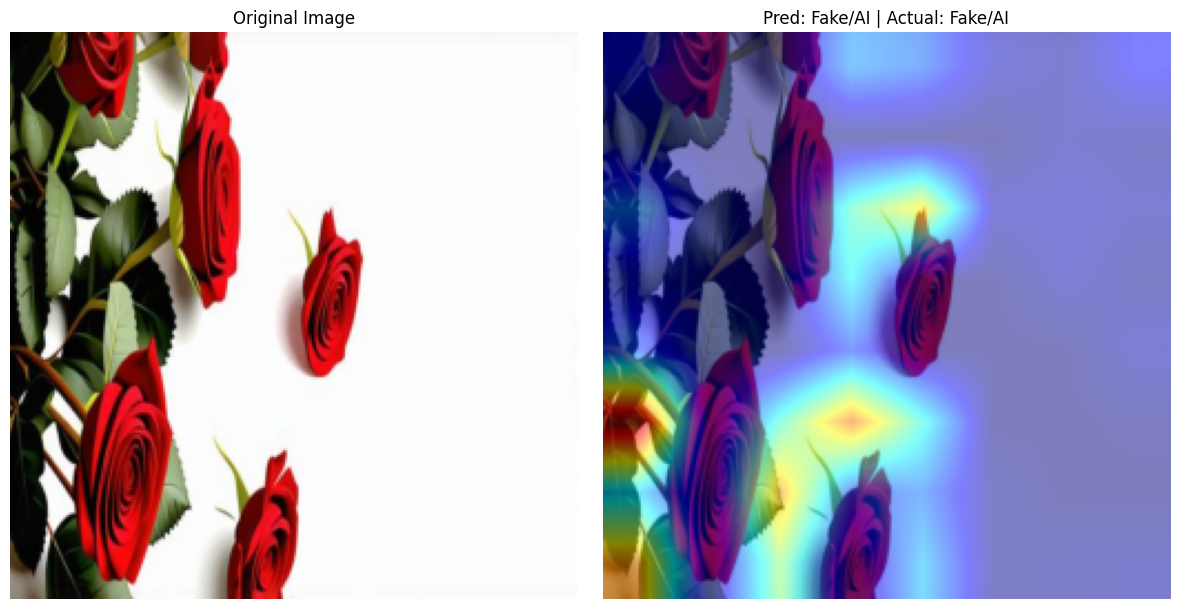

Processing: train\000ff55056384d61972bda1b6bd80701.jpg
Prediction: Fake/AI (Confidence: 0.5693) | Actual: Fake/AI


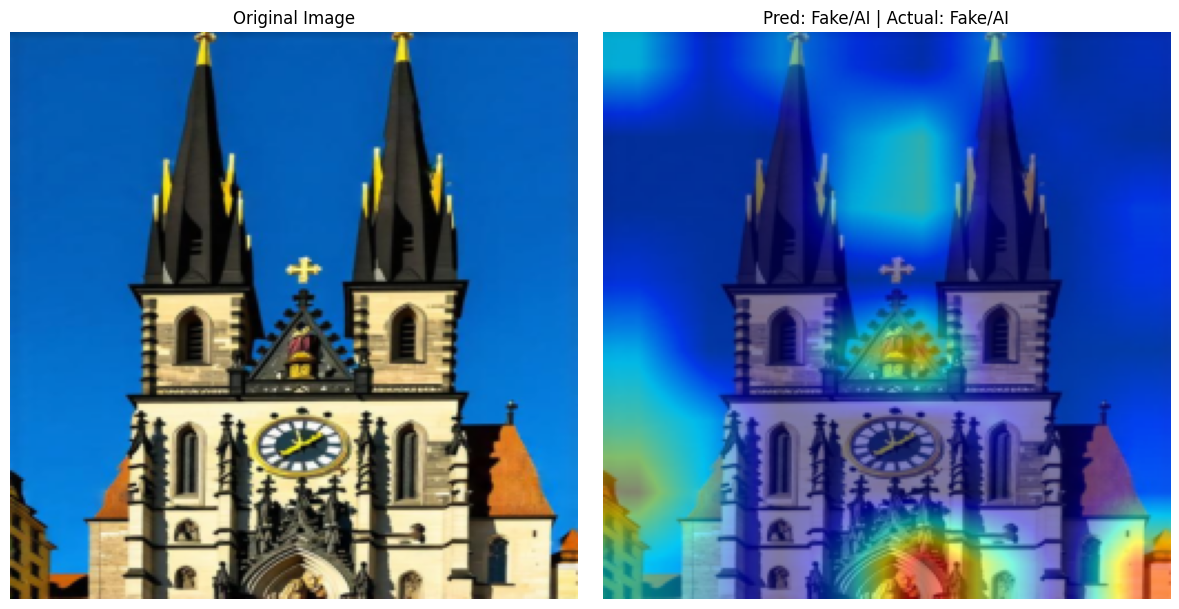

Processing: train\0014d21f66fc4946a2d0258182cd7e42.jpg
Prediction: Fake/AI (Confidence: 0.7040) | Actual: Fake/AI


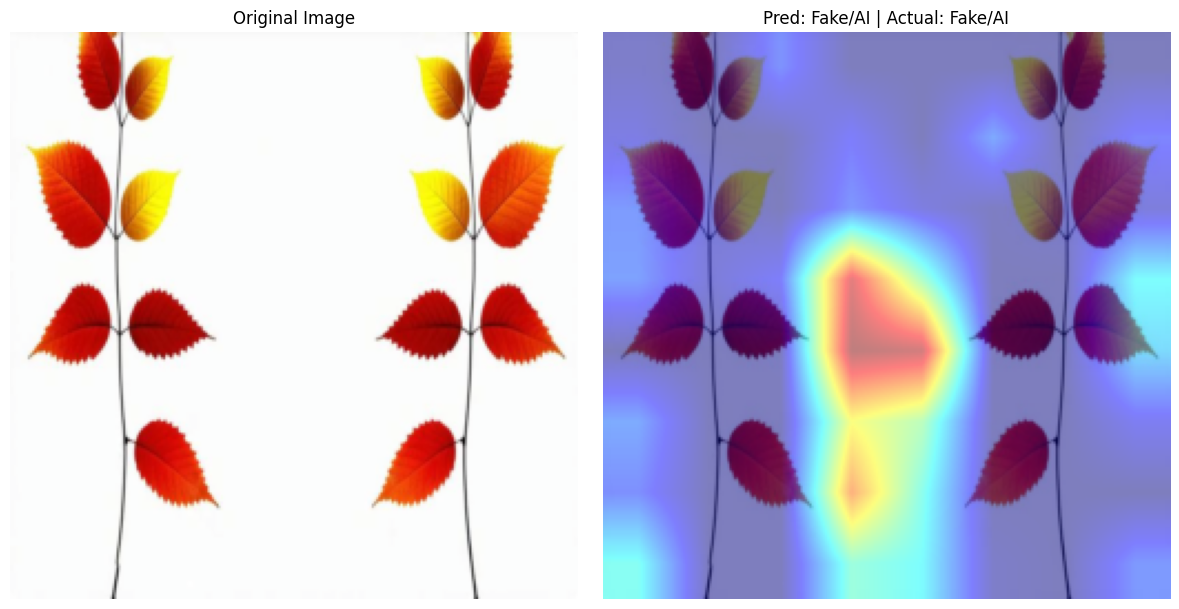

Processing: train\00184133eb7b4f058c974af14f7d1804.jpg
Prediction: Fake/AI (Confidence: 0.5805) | Actual: Real/Human


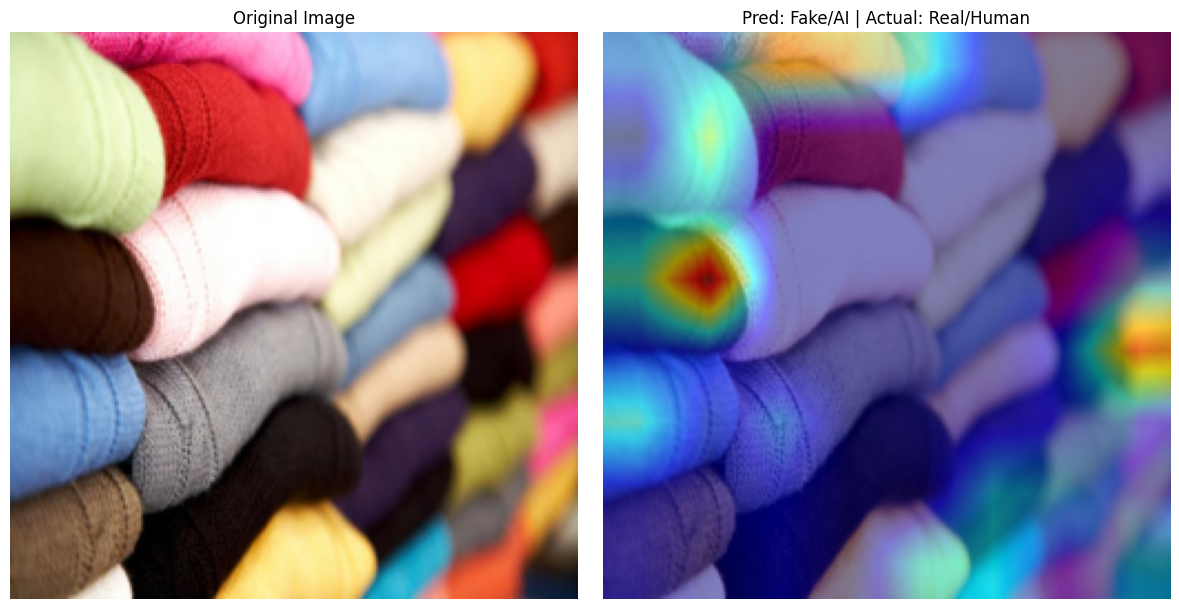

Processing: train\001bb73123984d97aef8a998f004caf4.jpg
Prediction: Real/Human (Confidence: 0.5219) | Actual: Fake/AI


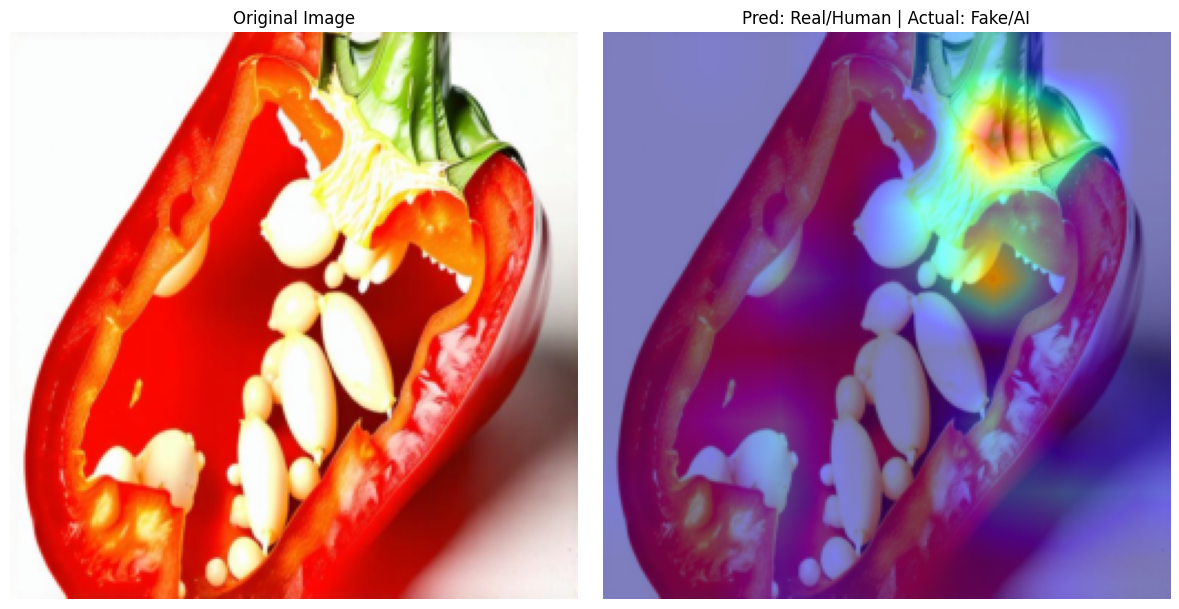

Processing: train\00293c1ed9864f10b6f52aad8aa81175.jpg


In [27]:
# 2. Process and Explain
for i, img_path in enumerate(image_paths):
    print(f"Processing: {img_path}")
    if i == N_RECORDS:
        break
    if os.path.exists(img_path):
        try:
            # Load Image
            image = Image.open(img_path).convert('RGB')
            input_tensor = val_transform(image)
            
            # Get Prediction
            with torch.no_grad():
                output = model(input_tensor.unsqueeze(0).to(DEVICE))
                probs = torch.nn.functional.softmax(output, dim=1)
                pred_idx = torch.argmax(probs).item()
                conf = probs[0][pred_idx].item()
                
            label_map = {0: "Real/Human", 1: "Fake/AI"}
            pred_label = label_map.get(pred_idx, str(pred_idx))
            
            # Get Actual Label
            actual_text = "Unknown"
            img_name = os.path.basename(img_path)
            if img_name in label_lookup:
                actual_val = label_lookup[img_name]
                actual_text = label_map.get(actual_val, str(actual_val))
            
            print(f"Prediction: {pred_label} (Confidence: {conf:.4f}) | Actual: {actual_text}")
            
            # Run Grad-CAM
            target_layer = get_target_layer(model, MODEL_NAME)
            if target_layer:
                heatmap = run_grad_cam(model, input_tensor, target_layer)
                save_path = f'{SAVE_DIR}/{img_name}'
                visualize_cam(input_tensor, heatmap, title=f"Pred: {pred_label} | Actual: {actual_text}", save_path=save_path)
            else:
                print("Could not identify target layer for this model architecture.")
                
        except Exception as e:
            print(f"Error during processing {img_path}: {e}")
    else:
        print(f"Image file not found: {img_path}")